<div style="background-color:#1e1e1e; padding:25px; border-radius:10px; display:table; width:100%;">

  <!-- Left column: text -->
  <div style="display:table-cell; vertical-align:top; width:70%; padding-right:10px;">
    <h1 style="color:#4FC3F7; margin-bottom:10px;">Hands-On Part B: Personalization Methods</h1>

  <p style="font-size:18px; font-style:italic; color:#cccccc;">
    Workshop on T1D Simulator and Digital Twins for Personalized Care
  </p>

  <p style="font-size:15px; line-height:1.6; color:#dddddd;">
fill
  </p>
  </div>

  <!-- Right column: logo -->
  <div style="display:table-cell; vertical-align:middle; text-align:left; width:30%; padding-right:50px;">
    <img src="https://micelab.udg.edu/wp-content/uploads/2022/08/MICElab-letras_png-300x119.png" alt="MiceLab Logo" style="height:80px; border-radius:8px;">
  </div>

</div>


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
0. Imports &amp; Set-Up
</h2>

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../scripts"))

In [2]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from sklearn.model_selection import train_test_split

from datetime import datetime
import pytz
from tqdm import tqdm
from scripts.data_classes import TrainingData
from scripts.gan import GANModel
from scripts.simulate import SimulatorVAEGAN

Check GPU availability for TensorFlow, not essential.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
Num GPUs Available: 0
GPUs: []


2025-09-19 14:21:06.479017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
import os, sys, contextlib, io

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # still useful for later logs
os.environ['ABSL_LOG_LEVEL']      = '3'

@contextlib.contextmanager
def mute_tensorflow_startup():
    """Silence C++ factory/placer warnings emitted during the first TF import."""
    stderr_fileno = sys.stderr.fileno()
    with open(os.devnull, 'w') as devnull:
        saved_stderr = os.dup(stderr_fileno)
        os.dup2(devnull.fileno(), stderr_fileno)   # redirect to /dev/null
        try:
            yield
        finally:
            os.dup2(saved_stderr, stderr_fileno)   # restore stderr
            os.close(saved_stderr)

with mute_tensorflow_startup():
    import tensorflow as tf

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # essential for indexing tensors, code crashes without this

<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
1. Load Model & Data
</h2>

Setup path and model name.

In [ ]:
path_to_model = "../misc/"
model_name = "pretrained-model.h5"

Load the .h5 using the `load_model` method from keras.

In [6]:
model_filename = Path(path_to_model, model_name)
pretrained_vae_model = tf.keras.models.load_model(model_filename)

In [7]:
path_df = Path("../data/data_processed.csv")

df = pd.read_csv(path_df)

display(df.head())

,ID,BG,PI,RA
0,11_0,134.0,0.000000,0.0
1,11_0,125.0,0.000271,0.0
2,11_0,132.0,0.001510,0.0
3,11_0,132.0,0.003488,0.0
4,11_0,132.0,0.006741,0.0


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2. Split Patient Data for Train / Validation
</h2>

In [8]:
split_size = 0.2
df_train, df_val = train_test_split(df, test_size=split_size, random_state=0, shuffle=True)

display(df_train.head())
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)

,ID,BG,PI,RA
1649,290_0,166.0,1.851760,0.231335
1465,290_0,63.0,0.834074,0.018890
361,11_0,109.0,0.436116,0.000001
315,11_0,93.0,0.275721,0.000246
1372,290_0,131.0,0.855476,0.032081


Train shape: (1382, 4)
Validation shape: (346, 4)


In [9]:
def manual_minmax_scaling(data: np.ndarray, scaler_range: tuple) -> tuple[np.ndarray, float, float]:
    """
    Perform manual min-max scaling on the data.

    Args:
        data (np.ndarray): Data to scale.
    Returns:
        Tuple[np.ndarray, float, float]: Scaled data, minimum value, and maximum value.
    """
    lower_bound = scaler_range[0]
    upper_bound = scaler_range[1]
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = lower_bound + (upper_bound - lower_bound) * (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

def individual_min_max_scaling(
    df: pd.DataFrame, base_output_dir: Path, scaler_range: tuple, gan_inputs: list
) -> pd.DataFrame:
    """
    Perform individual min-max scaling on the dataframe columns.
    Scale all three columns the same way and save only the scalers for 'BG'.

    Args:
        df (pd.DataFrame): Dataframe to scale.
        base_output_dir (Path): Directory to save the scalers.
    Returns:
        pd.DataFrame: Scaled dataframe.
    """
    scalers: dict[str, list[float]] = {'BG_min': [], 'BG_max': []}
    scaled_dfs: list[pd.DataFrame] = []

    for column in gan_inputs:
        if column not in ['BG', 'IG']:
            df[f'sc{column}'], _, _ = manual_minmax_scaling(df[column], scaler_range)

    df['scBG'], min_val, max_val = (manual_minmax_scaling(df['BG'], scaler_range))

    scalers['BG_min'].append(min_val)
    scalers['BG_max'].append(max_val)

    scaled_dfs.append(df)

    scaled_df = pd.concat(scaled_dfs, ignore_index=True)
    scaled_df = scaled_df.sort_values(by=['ID', 'iteration']).reset_index(drop=True)

    save_scalers(pd.DataFrame(scalers), base_output_dir)

    return scaled_df

def save_scalers(scalers_df: pd.DataFrame, base_output_dir: Path) -> None:
    """
    Save the scalers to a file.

    Args:
        scalers (Dict[str, List[float]]): Dictionary containing the scalers.
        base_output_dir (Path): Directory to save the scalers.
    """
    scalers_file: Path = Path(base_output_dir, 'bg_scalers.joblib')
    joblib.dump(scalers_df, scalers_file)

In [10]:
df_scaled = df.copy(deep=True)

df_scaled['iteration'] = df_scaled.groupby('ID').cumcount()
df_scaled = individual_min_max_scaling(df_scaled, '../misc/', (0,1), ['BG', 'RA', 'PI'])
# df_scaled.drop(columns=['PI', 'RA', 'iteration'], inplace=True)
df_scaled

,ID,BG,PI,RA,iteration,scRA,scPI,scBG
0,11_0,134.0,0.000000,0.000000,0,0.000000,0.000000,0.376984
1,11_0,125.0,0.000271,0.000000,1,0.000000,0.000097,0.341270
2,11_0,132.0,0.001510,0.000000,2,0.000000,0.000543,0.369048
3,11_0,132.0,0.003488,0.000000,3,0.000000,0.001253,0.369048
4,11_0,132.0,0.006741,0.000000,4,0.000000,0.002421,0.369048
...,...,...,...,...,...,...,...,...
1723,290_0,70.0,1.402729,0.052132,859,0.010609,0.503862,0.123016
1724,290_0,69.0,1.373106,0.047064,860,0.009577,0.493221,0.119048
1725,290_0,69.0,1.344499,0.042466,861,0.008642,0.482945,0.119048
1726,290_0,69.0,1.316954,0.038300,862,0.007794,0.473051,0.119048


In [11]:
def pack_data(df) -> None:
    """
    Pack the data into vectors for each feature (BG).

    This method creates packed vectors for blood glucose (BG)
    by sliding a window over the time series data. The packed data is then
    stored in new columns in the DataFrame.
    """
    df = df.fillna(0)  # Fill NaN values with 0

    # Pack blood glucose data
    packed_bg_vectors: np.ndarray = np.array(
        [
            df.iloc[i : i + 18]['scBG'].values
            for i in tqdm(range(len(df) - (18 - 1)), desc='Packing BG')
        ]
    )

    df = df.iloc[: len(packed_bg_vectors)]
    df['scBG_packed'] = list(packed_bg_vectors)
    df.reset_index(drop=True, inplace=True)
    return df

In [12]:
df_packed = pack_data(df_scaled)
display(df_packed)

Packing BG: 100%|██████████| 1711/1711 [00:00<00:00, 41368.57it/s]


,ID,BG,PI,RA,iteration,scRA,scPI,scBG,scBG_packed
0,11_0,134.0,0.000000,0.000000,0,0.000000,0.000000,0.376984,"[0.376984126984127, 0.3412698412698413, 0.3690..."
1,11_0,125.0,0.000271,0.000000,1,0.000000,0.000097,0.341270,"[0.3412698412698413, 0.36904761904761907, 0.36..."
2,11_0,132.0,0.001510,0.000000,2,0.000000,0.000543,0.369048,"[0.36904761904761907, 0.36904761904761907, 0.3..."
3,11_0,132.0,0.003488,0.000000,3,0.000000,0.001253,0.369048,"[0.36904761904761907, 0.36904761904761907, 0.3..."
4,11_0,132.0,0.006741,0.000000,4,0.000000,0.002421,0.369048,"[0.36904761904761907, 0.36507936507936506, 0.3..."
...,...,...,...,...,...,...,...,...,...
1706,290_0,189.0,1.856360,0.266009,842,0.054131,0.666806,0.595238,"[0.5952380952380952, 0.5515873015873016, 0.515..."
1707,290_0,178.0,1.853454,0.243603,843,0.049572,0.665762,0.551587,"[0.5515873015873016, 0.5158730158730159, 0.5, ..."
1708,290_0,169.0,1.843510,0.222789,844,0.045336,0.662190,0.515873,"[0.5158730158730159, 0.5, 0.47619047619047616,..."
1709,290_0,165.0,1.827765,0.203503,845,0.041412,0.656535,0.500000,"[0.5, 0.47619047619047616, 0.44841269841269843..."


In [13]:
gan_inputs = ['BG', 'scBG_packed', 'PI', 'RA', 'scPI', 'scRA']
data_dict = {column: np.array(df_packed[column].tolist(), dtype=np.float32).reshape(df_packed.shape[0], 1, -1) for column in gan_inputs}

In [14]:
def load_training_data(df):
    train_data_dict = {}
    for input_name in gan_inputs:
        if input_name == 'scBG_packed':
            train_data_dict['scBG'] = df[f'{input_name}']
        elif input_name in ['BG', 'PI', 'RA']:
            pass
        else:
            train_data_dict[f'{input_name}'] = df[f'{input_name}']

    train_data = TrainingData(**train_data_dict)
    return train_data

In [15]:
training_data = load_training_data(data_dict)

In [16]:
gan = GANModel(pretrained_vae_model)

try:
    history = gan.train(training_data)
except KeyboardInterrupt:
    print('Process interrupted by user')

GAN Training: 100%|██████████| 2650/2650 [01:35<00:00, 27.88step/s]


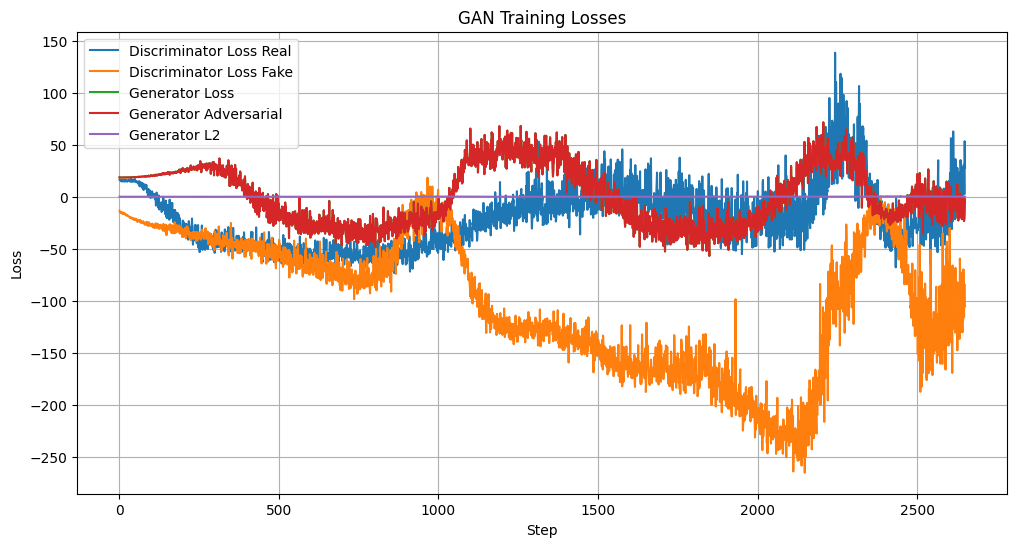

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history['step'], history['d_loss_real'], label='Discriminator Loss Real')
plt.plot(history['step'], history['d_loss_fake'], label='Discriminator Loss Fake')
plt.plot(history['step'], history['g_loss'], label='Generator Loss')
plt.plot(history['step'], history['g_adversarial'], label='Generator Adversarial')
plt.plot(history['step'], history['g_l2'], label='Generator L2')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
timezone = pytz.timezone('Europe/Madrid')
timestamp = datetime.now(timezone).strftime('%Y%m%d_%H%M%S')
gan.g_model.save(f'../misc/generator_model_{timestamp}.h5')

/home/oriol/workspace/t1d-data-based-digital-twin/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Simulation

In [19]:
@dataclass
class SimulationData:
    """
    Data class containing the simulation dynamical inputs, results and some minor settings.
    """
    # Blood Glucose
    gen_bg_scaled_arrays: np.ndarray

    real_bg_scaled: np.ndarray
    real_bg_unscaled: np.ndarray
    gen_bg_unscaled: np.ndarray = None

    PI_scaled: np.ndarray = None
    RA_scaled: np.ndarray = None
    PA_scaled: np.ndarray = None
    IG_scaled: np.ndarray = None

    # Plotting data
    PI_unscaled: np.ndarray = None
    RA_unscaled: np.ndarray = None
    PA_unscaled: np.ndarray = None
    IG_unscaled: np.ndarray = None

In [20]:
def load_patient_sim_data(data_dict, simulation_length: int) -> SimulationData:
    real_bg_unscaled = data_dict['BG']  # take the original vector to compare against the generated profile
    real_bg_scaled = data_dict['scBG_packed']  # this is packed
    gan_inputs = ['BG', 'scBG_packed', 'PI', 'RA']

    # Calculate the number of days to simulate
    days_to_simulate = min(len(real_bg_unscaled) / 288, simulation_length)
    time_steps = int(288 * days_to_simulate)

    sim_data_dict = {
        'real_bg_unscaled': real_bg_unscaled.ravel()[:time_steps],
        'real_bg_scaled': real_bg_scaled[:, 0, 0][:time_steps],
    }

    for input_name in gan_inputs:
        if input_name != 'BG' and input_name != 'scBG_packed':
            sim_data_dict[f'{input_name}_scaled'] = data_dict[f'sc{input_name}']
            sim_data_dict[f'{input_name}_unscaled'] = data_dict[input_name]

    sim_data_dict['gen_bg_scaled_arrays'] = np.zeros(
        (
            1,
            time_steps,
            time_steps + 18,
        )
    )

    sim_data = SimulationData(**sim_data_dict)
    return sim_data

In [21]:
# load from misc the .h5
generator = tf.keras.models.load_model(f'../misc/generator_model_{timestamp}.h5')

In [22]:
simulation_length = 2
scalers_path = '../misc/'

input_sim_data = load_patient_sim_data(data_dict, simulation_length=simulation_length)
simulator_instance = SimulatorVAEGAN()
simulated_data = simulator_instance.simulate(input_sim_data, generator, simulation_length, scalers_path)

100%|██████████| 575/575 [00:04<00:00, 137.06it/s]


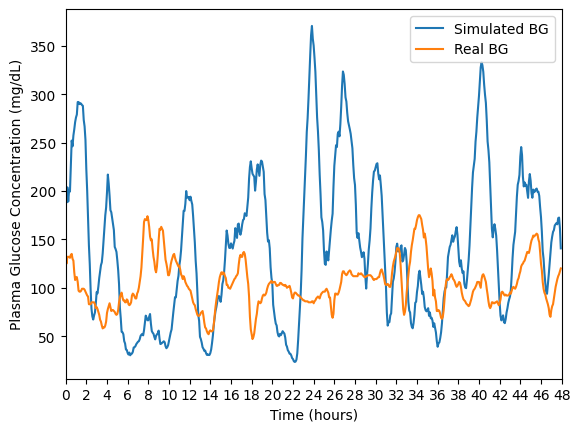

In [23]:
num_points = len(simulated_data.gen_bg_unscaled)
x_hours = np.arange(num_points) * 5 / 60  # 5 min per sample, convert to hours
plt.xlabel('Time (hours)')
plt.ylabel('Plasma Glucose Concentration (mg/dL)')
plt.xticks(
    ticks=np.arange(0, x_hours[-1]+1, 2),
    labels=[f"{int(t)}" for t in np.arange(0, x_hours[-1]+1, 2)]
)
plt.gca().set_xlim([0, x_hours[-1]])
plt.gca().set_xticks(np.arange(0, x_hours[-1]+1, 2))
plt.gca().set_xticklabels([f"{int(t)}" for t in np.arange(0, x_hours[-1]+1, 2)])
plt.plot(x_hours, simulated_data.gen_bg_unscaled, label='Simulated BG')
plt.plot(x_hours, simulated_data.real_bg_unscaled, label='Real BG')
plt.legend()
plt.show()